In [1]:
import sys
import os

pwd = os.path.dirname(os.path.realpath('__file__'))
print(pwd)

sys.path.append(pwd + "../")
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "geodjango.settings")
import django
import numpy as np
import pandas as pd
import pyflux as pf
import types
from datetime import datetime
import matplotlib.pyplot as plt
django.setup()
from django.db.models import Count, Sum, Avg
from taxi.models import Trip,Edge,District
from django.db.models import Q
from django.db.models import Func, F

D:\DataMiningLab\geodjango


In [2]:
def label():
    return District.objects.get(pk=tail).name+'->'+District.objects.get(pk=head).name
def target():
    return 'd'+str(tail)+'_d'+str(head)
neighbour_day_tab = pd.read_pickle('daily_table')
neighbour_day_tab.columns = [neighbour_day_tab.columns.map('d{0[0]}_d{0[1]}'.format)]
y = pd.DataFrame(neighbour_day_tab.values)
y.index = neighbour_day_tab.index#pd.DatetimeIndex(.values.astype(datetime),dtype=datetime)
y.columns = neighbour_day_tab.columns.get_level_values(0)

In [53]:
neighbour_day_tab.to_pickle('daily_table')

In [4]:
class Day(Func):
    function = 'date_trunc'
    template = '%(function)s(\'day\',%(expressions)s)'
def edges():
    return Edge.objects.all().filter(tripset = 29)
tail = 190
head = 170

neighbour_tail = edges().filter(tail=tail).exclude(head=tail).exclude(head=head).order_by('-weight')[:3].values_list('head',flat=True)
neighbour_head = edges().filter(head=head).exclude(tail=head).exclude(tail=tail).order_by('-weight')[:3].values_list('tail',flat=True)
neighbour_day = Trip.objects.all().filter(Q(Q(pickupDistrict=tail),Q(dropoffDistrict__in=neighbour_tail))|  \
                                          Q(Q(dropoffDistrict=head),Q(pickupDistrict__in=neighbour_head))|  \
                                          Q(Q(dropoffDistrict=tail),Q(pickupDistrict=head))|  \
                                          Q(Q(dropoffDistrict=head),Q(pickupDistrict=tail))).values('pickupDistrict','dropoffDistrict').order_by(). \
        annotate(weight=Count('pk'),total_amount=Avg('totalAmount'),day=Day('pickupTime'))
neighbour_day_array = np.array(list(neighbour_day.values_list('day','pickupDistrict','dropoffDistrict','weight'))) 
neighbour_day_tab = pd.pivot_table(pd.DataFrame(neighbour_day_array), values=3, index=0,
                     columns=[1,2], aggfunc=np.sum)

neighbour_day_tab.columns.names = list(['pickup', 'dropoff'])
neighbour_day_tab.columns

MultiIndex(levels=[[104, 170, 171, 190, 228], [104, 106, 115, 170, 190]],
           labels=[[0, 1, 2, 3, 3, 3, 3, 4], [3, 4, 3, 0, 1, 2, 3, 3]],
           names=['pickup', 'dropoff'])

d:\ProgramData\Anaconda3\envs\python34\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


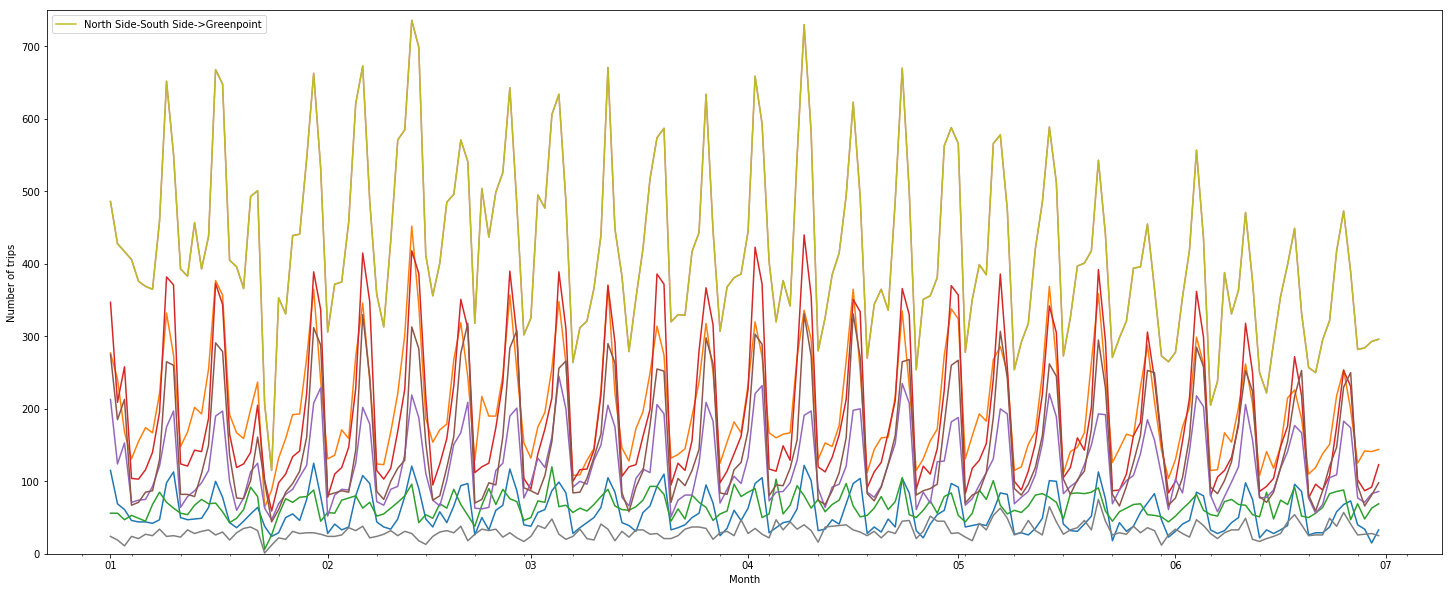

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MO
from taxi.models import Trip,Edge,District
fig, ax = plt.subplots(figsize=(25, 10))
months = mdates.MonthLocator()  # every month\
weeks = mdates.WeekdayLocator(byweekday=MO)
monthsFmt = mdates.DateFormatter('%m')
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(weeks)
ax.set_xlabel("Month")
ax.set_ylabel("Number of trips")
ax.plot_date(neighbour_day_tab.index.to_pydatetime(), neighbour_day_tab.values, '-')
ax.plot_date(neighbour_day_tab.index.to_pydatetime(), neighbour_day_tab[tail,head].values, '-',label=label())
ax.legend(loc='upper left')
ax.set_ylim([0,750])
fig.show()

In [6]:
#model = pf.GARCH(neighbour_day_tab[tail,head].values,p=3,q=3)target = '190->170'
import pyflux as pf
import matplotlib.pyplot as plt
def plot_fit(self,**kwargs):
    """ 
    Plots the fit of the model against the data
    """
    import seaborn as sns
    import matplotlib.dates as mdates
    from matplotlib.dates import MO
    months = mdates.MonthLocator()  # every month\
    weeks = mdates.WeekdayLocator(byweekday=MO)
    monthsFmt = mdates.DateFormatter('%m')

    figsize = kwargs.get('figsize',(10,7))
    plt.figure(figsize=figsize)
    date_index = self.index[max(self.ar, self.ma):self.data_length].to_pydatetime()
    mu, Y = self._model(self.latent_variables.get_z_values())

    # Catch specific family properties (imply different link functions/moments)
    if self.model_name2 == "Exponential":
        values_to_plot = 1.0/self.link(mu)
    elif self.model_name2 == "Skewt":
        t_params = self.transform_z()
        model_scale, model_shape, model_skewness = self._get_scale_and_shape(t_params)
        m1 = (np.sqrt(model_shape)*sp.gamma((model_shape-1.0)/2.0))/(np.sqrt(np.pi)*sp.gamma(model_shape/2.0))
        additional_loc = (model_skewness - (1.0/model_skewness))*model_scale*m1
        values_to_plot = mu + additional_loc
    else:
        values_to_plot = self.link(mu)

    plt.plot_date(date_index, Y,'-', label='Data')
    plt.plot_date(date_index, values_to_plot,'-', label='ARIMA model', c='black')
    plt.title(label())#(self.data_name)
    plt.legend(loc=2)   
    plt.show()

def plot_predict(self, h=10, past_values=10, intervals=True, **kwargs):
    figsize=(20,5)
    time = neighbour_day_tab[-60:].index.to_pydatetime()
    val =  neighbour_day_tab[target()].values[-60:]
    self = pf.ARIMA(data=y[:-10],target = target(), ar=7, ma=7, family=pf.Normal())
    self.fit("MLE")
    self.plot_predict(h, past_values, intervals,figsize=figsize, **kwargs)
    plt.plot_date(time, val, '-',label=label())
    plt.legend()
    plt.show()
    self = pf.ARIMA(data=y[:-20],target = target(), ar=7, ma=7, family=pf.Normal())
    self.fit("MLE")
    self.plot_predict(h, past_values, intervals,figsize=figsize, **kwargs)
    plt.plot_date(time, val, '-',label=label())
    plt.legend()
    plt.show()
    self = pf.ARIMA(data=y[:-30],target = target(), ar=7, ma=7, family=pf.Normal())
    self.fit("MLE")
    self.plot_predict(h, past_values, intervals,figsize=figsize, **kwargs)
    plt.plot_date(time, val, '-',label=label())
    plt.legend()
    plt.show()
tail = 190
head = 170
model = pf.ARIMA(data=y,target = target(), ar=7, ma=7, family=pf.Normal())
#print(type(model))
model.plot_fit = types.MethodType(plot_fit, model)
x = model.fit("MLE")
x.summary()

Normal ARIMA(7,0,7)                                                                                       
======================================================= ==================================================
Dependent Variable: 190->170                            Method: MLE                                       
Start Date: 2016-01-08 00:00:00                         Log Likelihood: -981.3449                         
End Date: 2016-06-30 00:00:00                           AIC: 1994.6899                                    
Number of observations: 175                             BIC: 2045.3265                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 423.1441   11.8228    35.7906  0.0      (399.9715 | 446.3168)    
AR(1)                                

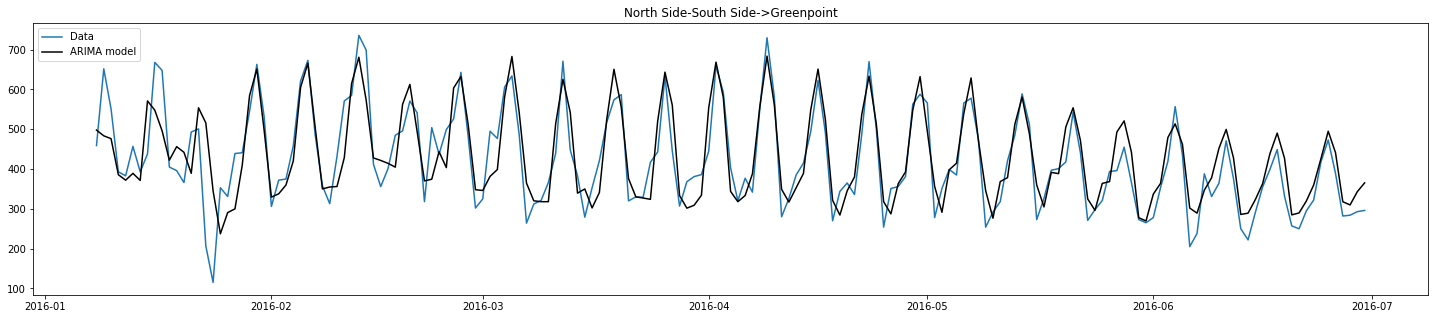

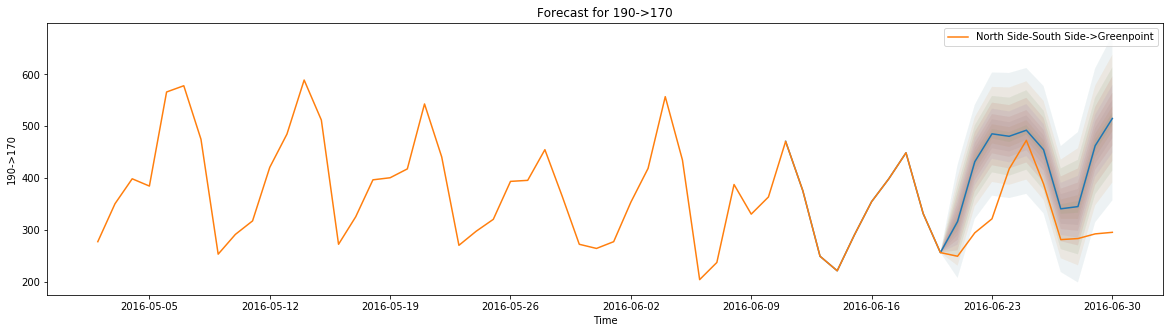

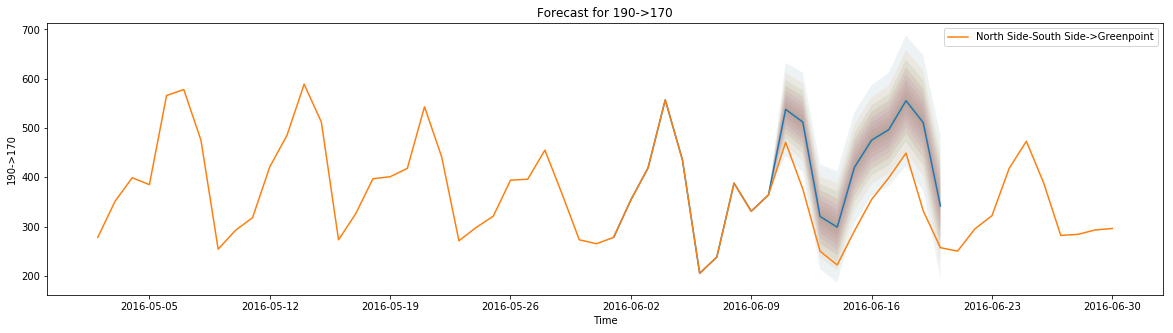

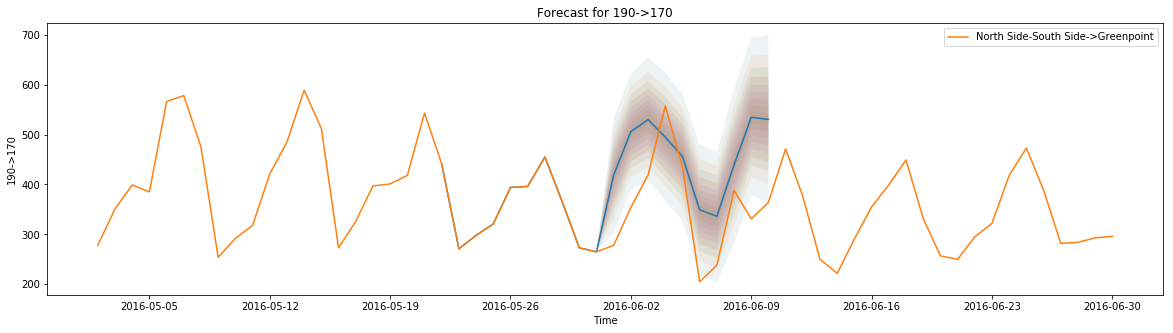

In [7]:
model.plot_fit(figsize=(25,5))
plot_predict(model)

Normal ARIMAX(7,0,7)                                                                                      
======================================================= ==================================================
Dependent Variable: d190_d170                           Method: MLE                                       
Start Date: 2016-01-08 00:00:00                         Log Likelihood: -869.2926                         
End Date: 2016-06-30 00:00:00                           AIC: 1784.5852                                    
Number of observations: 175                             BIC: 1857.3753                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.095      0.0508     1.8699   0.0615   (-0.0046 | 0.1946)       
AR(2)                                

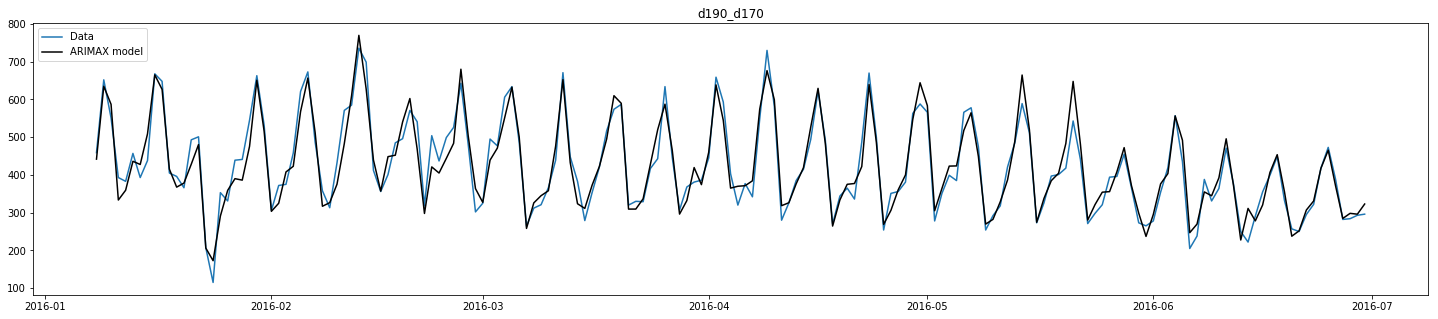

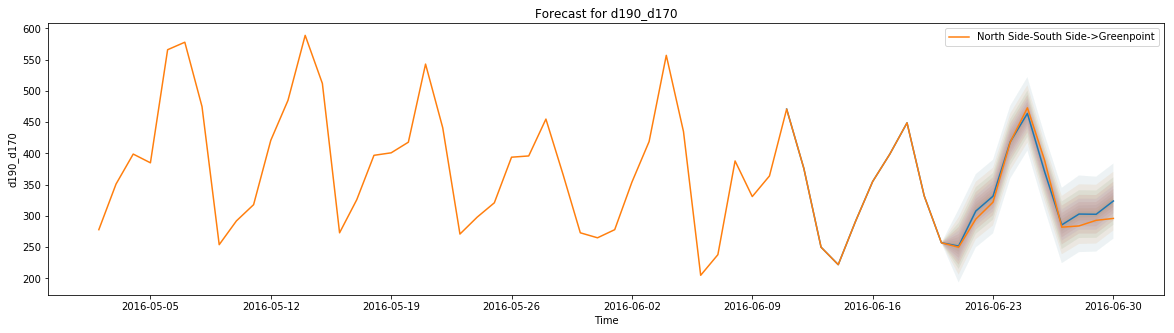

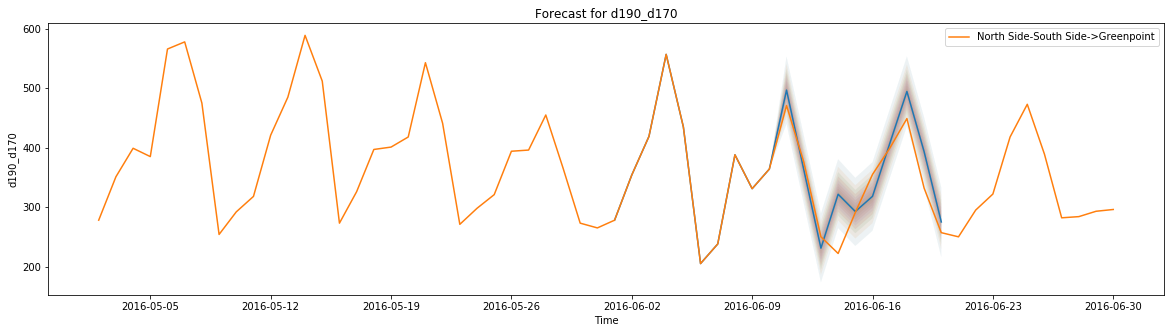

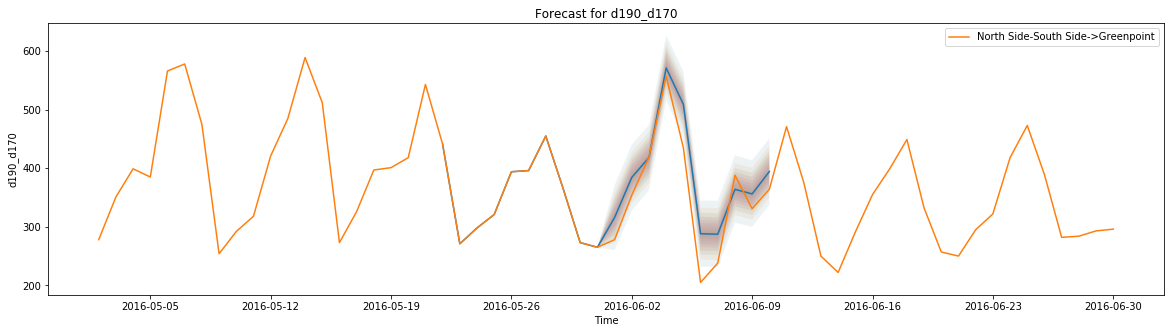

In [3]:
def plot_fit_x(self,**kwargs):
    """ 
    Plots the fit of the model against the data
    """
    import seaborn as sns
    import matplotlib.dates as mdates
    from matplotlib.dates import MO
    months = mdates.MonthLocator()  # every month\
    weeks = mdates.WeekdayLocator(byweekday=MO)
    monthsFmt = mdates.DateFormatter('%m')
    
    figsize = kwargs.get('figsize',(10,7))
    plt.figure(figsize=figsize)
    date_index = self.index[max(self.ar, self.ma):self.data.shape[0]].to_pydatetime()
    mu, Y = self._model(self.latent_variables.get_z_values())

    # Catch specific family properties (imply different link functions/moments)
    if self.model_name2 == "Exponential":
        values_to_plot = 1.0/self.link(mu)
    elif self.model_name2 == "Skewt":
        t_params = self.transform_z()
        model_scale, model_shape, model_skewness = self._get_scale_and_shape(t_params)
        m1 = (np.sqrt(model_shape)*sp.gamma((model_shape-1.0)/2.0))/(np.sqrt(np.pi)*sp.gamma(model_shape/2.0))
        additional_loc = (model_skewness - (1.0/model_skewness))*model_scale*m1
        values_to_plot = mu + additional_loc
    else:
        values_to_plot = self.link(mu)

    plt.plot_date(date_index, Y, '-',label='Data')
    plt.plot_date(date_index, values_to_plot, '-',label='ARIMAX model', c='black')
    plt.title(self.data_name)
    plt.legend(loc=2)   
    plt.show()          

def plot_predict_x(self, h=10, past_values=10, intervals=True, **kwargs):
    figsize=(20,5)
    time = neighbour_day_tab[-60:].index.to_pydatetime()
    val =  neighbour_day_tab[target()].values[-60:]
    self = pf.ARIMAX(data=y[:-10], ar=7, ma=7,formula=formula(),family=pf.Normal())
    self.fit("MLE")
    self.plot_predict(h, past_values, intervals,figsize=figsize,oos_data=y[-10:], **kwargs)
    plt.plot_date(time, val, '-',label=label())
    plt.legend()
    plt.show()
    self = pf.ARIMAX(data=y[:-20], ar=7, ma=7,formula=formula(), family=pf.Normal())
    self.fit("MLE")
    self.plot_predict(h, past_values, intervals,figsize=figsize,oos_data=y[-20:], **kwargs)
    plt.plot_date(time, val, '-',label=label())
    plt.legend()
    plt.show()
    self = pf.ARIMAX(data=y[:-30], ar=7, ma=7,formula=formula(), family=pf.Normal())
    self.fit("MLE")
    self.plot_predict(h, past_values, intervals,figsize=figsize,oos_data=y[-30:], **kwargs)
    plt.plot_date(time, val, '-',label=label())
    plt.legend()
    plt.show()
def formula():
    return target()+'~1+'+'+'.join([str(x) for x in y.columns.values[y.columns.values!=target()]])
tail = 190
head = 170
modelx = pf.ARIMAX(data=y,ar=7, ma=7,formula=formula(), family=pf.Normal())
#print(type(model))
modelx.plot_fit = types.MethodType(plot_fit_x, modelx)
xx = modelx.fit("MLE")
xx.summary()
modelx.plot_fit(figsize=(25,5))
plot_predict_x(modelx)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MO
from taxi.models import Trip,Edge,District
fig, ax = plt.subplots(figsize=(25, 10))
months = mdates.MonthLocator()  # every month\
weeks = mdates.WeekdayLocator(byweekday=MO)
monthsFmt = mdates.DateFormatter('%m')
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(weeks)
ax.set_xlabel("Month")
ax.set_ylabel("Number of trips")
#ax.plot_date(neighbour_day_tab.index.to_pydatetime(), neighbour_day_tab.values, '-')
ax.plot_date(neighbour_day_tab.index.to_pydatetime(), neighbour_day_tab[str(tail)+'->'+str(head)].values, '-',label=District.objects.get(pk=tail).name+'->'+District.objects.get(pk=head).name)
ax.legend(loc='upper left')
#ax.set_ylim([0,750])
fig.show()

In [8]:
y

,d104_d170,d170_d190,d171_d170,d190_d104,d190_d106,d190_d115,d190_d170,d228_d170
0,,,,,,,,
2016-01-01,115,277,56,347,213,275,486,24
2016-01-02,69,241,56,209,124,185,428,19
2016-01-03,61,168,47,258,153,213,417,11
2016-01-04,46,131,53,104,71,67,406,24
2016-01-05,44,155,49,103,74,71,376,21
2016-01-06,44,174,45,116,75,85,369,27
2016-01-07,42,167,68,140,93,87,365,25
2016-01-08,47,221,85,195,121,130,459,34
2016-01-09,98,332,71,382,175,265,652,24


In [78]:
neighbour_day_tab

,104->170,170->190,171->170,190->104,190->106,190->115,190->170,228->170
0,,,,,,,,
2016-01-01,115,277,56,347,213,275,486,24
2016-01-02,69,241,56,209,124,185,428,19
2016-01-03,61,168,47,258,153,213,417,11
2016-01-04,46,131,53,104,71,67,406,24
2016-01-05,44,155,49,103,74,71,376,21
2016-01-06,44,174,45,116,75,85,369,27
2016-01-07,42,167,68,140,93,87,365,25
2016-01-08,47,221,85,195,121,130,459,34
2016-01-09,98,332,71,382,175,265,652,24


In [82]:
neighbour_day_tab.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2016-06-21', '2016-06-22', '2016-06-23', '2016-06-24',
               '2016-06-25', '2016-06-26', '2016-06-27', '2016-06-28',
               '2016-06-29', '2016-06-30'],
              dtype='datetime64[ns]', name=0, length=182, freq=None)

In [123]:
data['time'].values

array([1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710,
       1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721,
       1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732,
       1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743,
       1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754,
       1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765,
       1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776,
       1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787,
       1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798,
       1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809,
       1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820,
       1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831,
       1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842,
       1843, 1844, 1845, 1846, 1847, 1848, 1849, 18

In [11]:
y[:-30]

,104->170,170->190,171->170,190->104,190->106,190->115,190->170,228->170
0,,,,,,,,
2016-01-01,115,277,56,347,213,275,486,24
2016-01-02,69,241,56,209,124,185,428,19
2016-01-03,61,168,47,258,153,213,417,11
2016-01-04,46,131,53,104,71,67,406,24
2016-01-05,44,155,49,103,74,71,376,21
2016-01-06,44,174,45,116,75,85,369,27
2016-01-07,42,167,68,140,93,87,365,25
2016-01-08,47,221,85,195,121,130,459,34
2016-01-09,98,332,71,382,175,265,652,24


'104->170+170->190+171->170+190->104+190->106+190->115+228->170'

In [20]:
#!pip install pandas-datareader
import numpy as np
import pyflux as pf
from pandas_datareader import data
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
a = data.DataReader('AMZN',  'yahoo', datetime(2012,1,1), datetime(2016,6,1))
a_returns = pd.DataFrame(np.diff(np.log(a['Adj Close'].values)))
a_returns.index = a.index.values[1:a.index.values.shape[0]]
a_returns.columns = ["JPM Returns"]

#ibm = data.DataReader(['JPM','GS','BAC','C','WFC','MS'],  'yahoo', datetime(2012,1,1), datetime(2016,6,28))
#opening_prices=np.log(ibm['Open'])

VAR(2)                                                                                                    
======================================================= ==================================================
Dependent Variable: Differenced BAC,Differenced C,Diffe Method: OLS                                       
Start Date: 2016-06-24 00:00:00                         Log Likelihood: 21542.5366                        
End Date: 2012-01-03 00:00:00                           AIC: 1.53341737675e+30                            
Number of observations: 1126                            BIC: 1.53341737675e+30                            
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Differenced BAC Constant                 -0.0009    0.0006     -1.5099  0.1311   (-0.002 | 0.0003)        
Differenced BAC AR(1)                

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

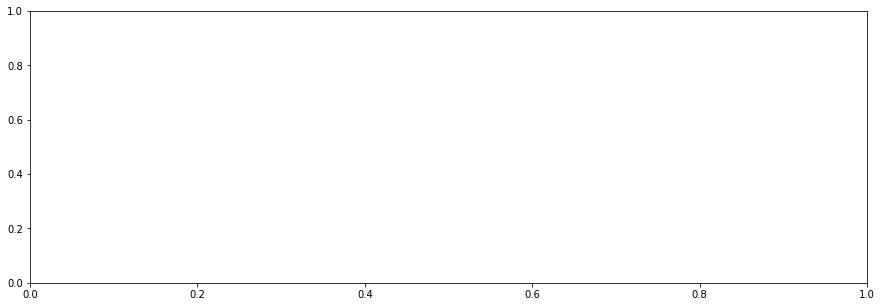

In [3]:
model = pf.VAR(data=opening_prices, lags=2, integ=1)
x = model.fit()
x.summary()
model.plot_predict(past_values=19, h=5, figsize=(15,5))